In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns
import matplotlib.pylab as plt

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
class GruCell(nn.Module):
    def __init__(self, hidden_size = 10):
        super(GruCell, self).__init__()
        self.my_reset = nn.Linear(hidden_size, hidden_size)
        self.my_update = nn.Linear(hidden_size, hidden_size)
        self.my_final = nn.Linear(hidden_size, hidden_size)
        self.neighbours_reset = nn.Linear(4 * hidden_size, hidden_size)
        self.neighbours_update = nn.Linear(4 * hidden_size, hidden_size)
        self.neighbours_final = nn.Linear(4 * hidden_size, hidden_size)

    def forward(self, state, x):
        reset_chooser = torch.sigmoid(self.my_reset(state) + self.neighbours_reset(x))
        resetted = reset_chooser * state
        update_chooser = torch.sigmoid(self.my_update(state) + self.neighbours_update(x))
        update = torch.tanh(self.my_final(resetted) + self.neighbours_final(x))
        update = update_chooser * update
        new_state = (1 - update_chooser) * state + update
        return reset_chooser, update_chooser, update, new_state

In [5]:
def autism_loss(reset, update, delta, state):
    return - torch.mean(reset ** 2) - torch.mean(update ** 2)  - torch.mean(state ** 2) + torch.mean(delta ** 2)

In [6]:
field_size = 102
hidden_size = 8
epochs = 100
batch_size = 32

In [18]:
net = GruCell(hidden_size).to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [19]:
field = torch.randn(field_size, field_size, hidden_size)
# зануляем края
for i in range(field_size):
    for j in range(field_size):
        if i == 0 or j == 0 or i == field_size - 1 or j == field_size - 1:
            field[i, j] = torch.zeros(hidden_size)

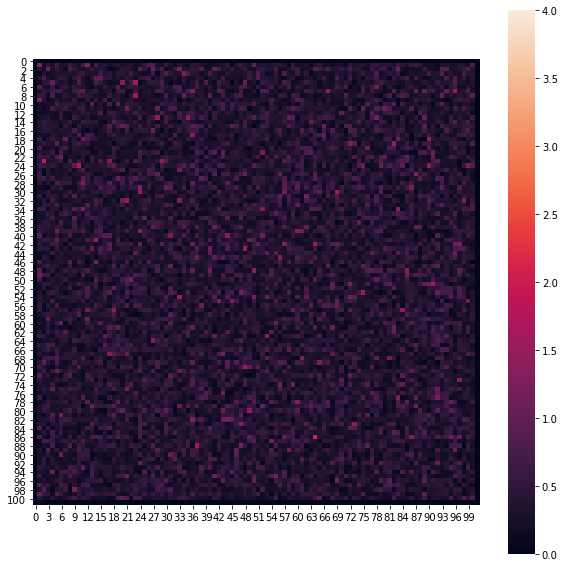

[1] loss: -0.911; Mean Information : 0.46986210346221924


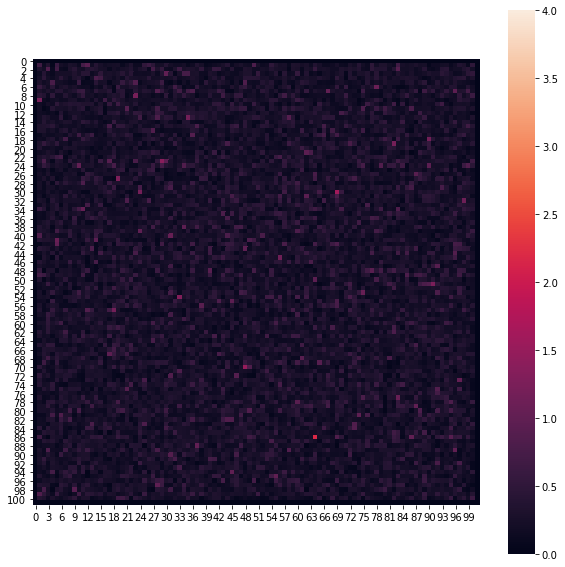

[2] loss: -0.857; Mean Information : 0.3533293902873993


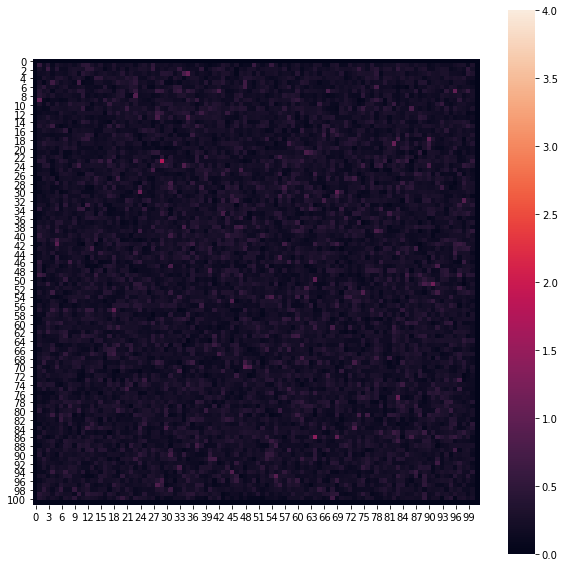

[3] loss: -0.948; Mean Information : 0.320469468832016


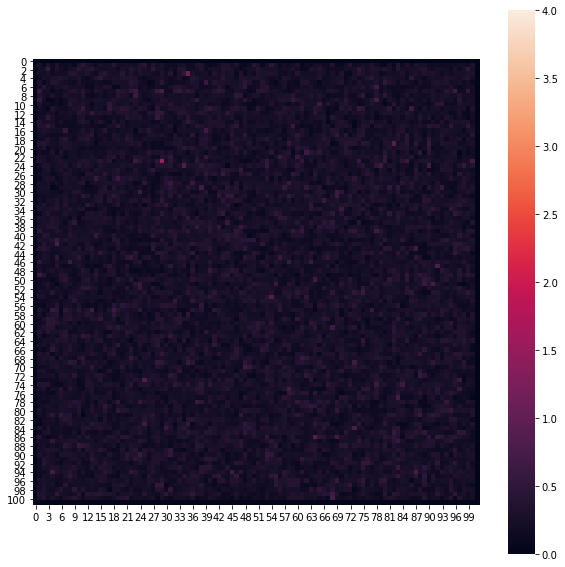

[4] loss: -1.140; Mean Information : 0.332171231508255


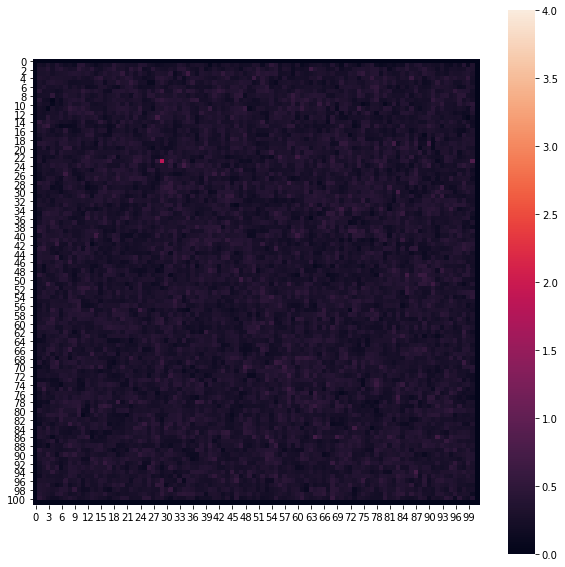

[5] loss: -1.397; Mean Information : 0.3786882162094116


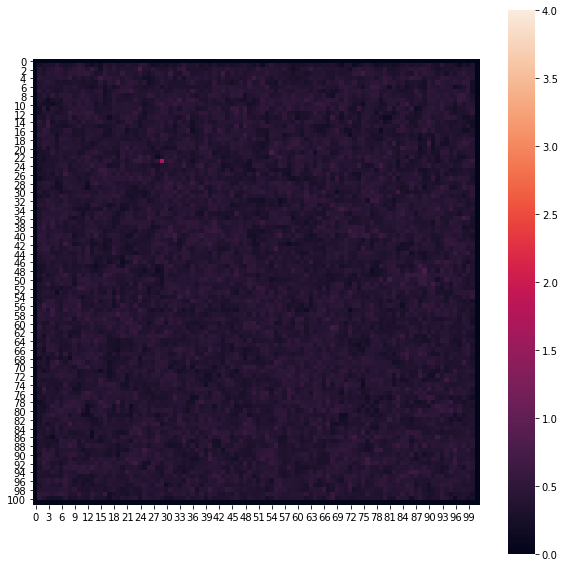

[6] loss: -1.654; Mean Information : 0.4586213529109955


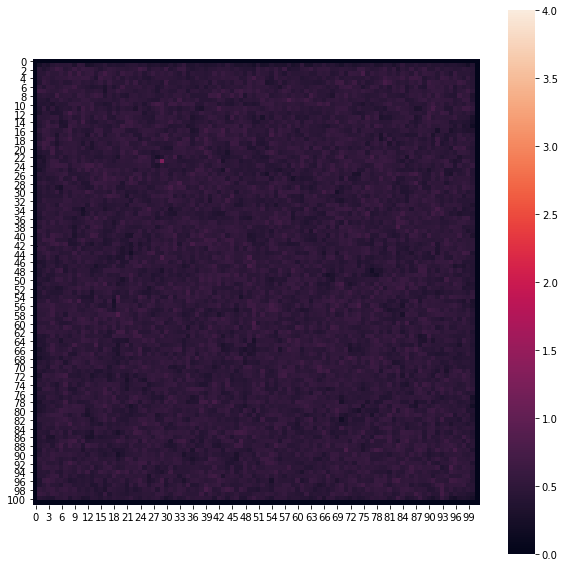

[7] loss: -1.836; Mean Information : 0.5600138902664185


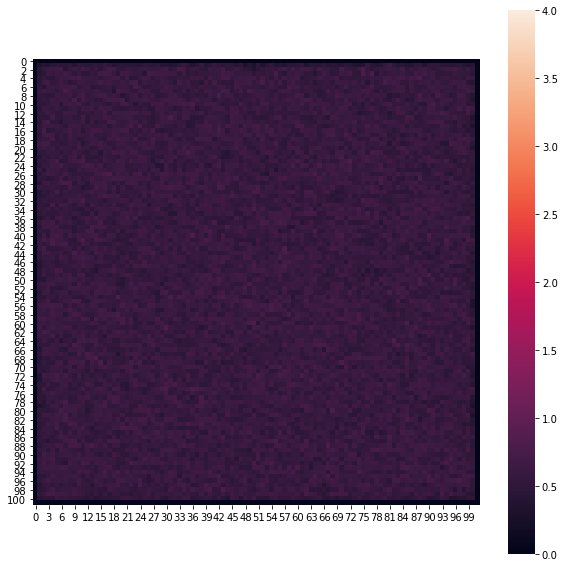

[8] loss: -1.927; Mean Information : 0.6483255624771118


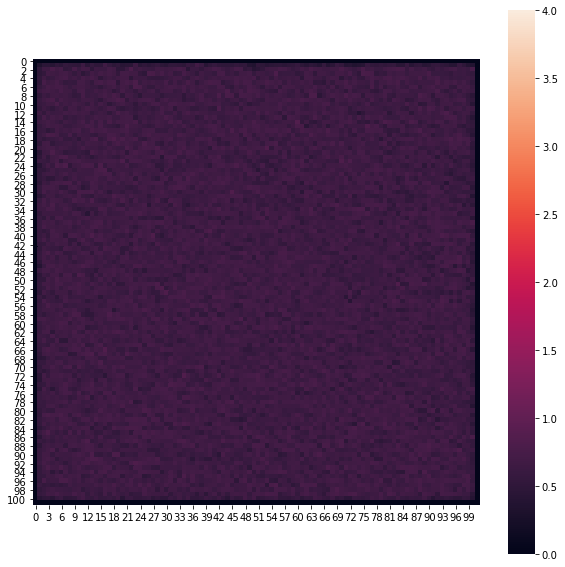

[9] loss: -1.962; Mean Information : 0.7144737243652344


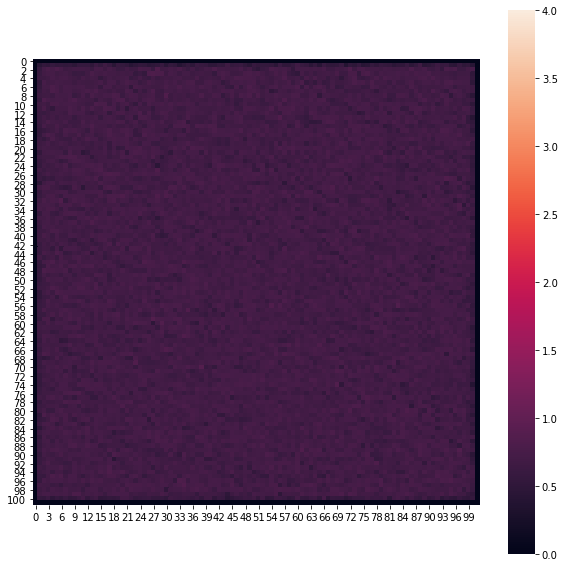

[10] loss: -1.976; Mean Information : 0.7554760575294495


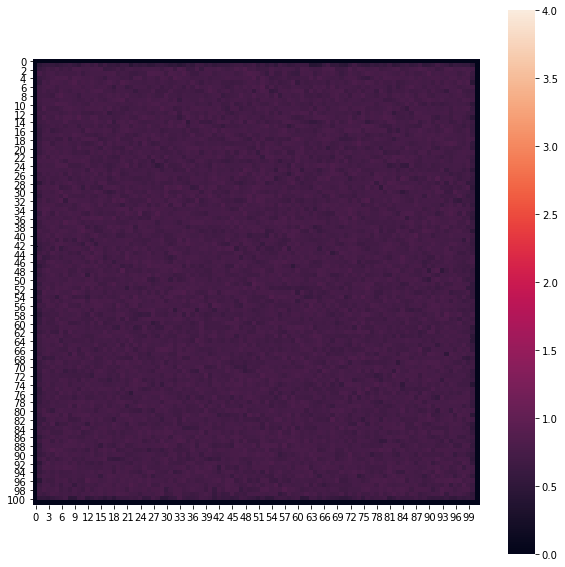

[11] loss: -1.982; Mean Information : 0.7810661196708679


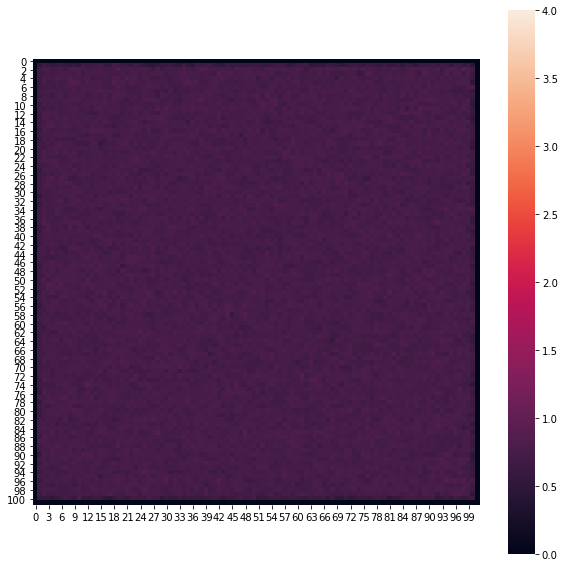

[12] loss: -1.986; Mean Information : 0.7990913987159729


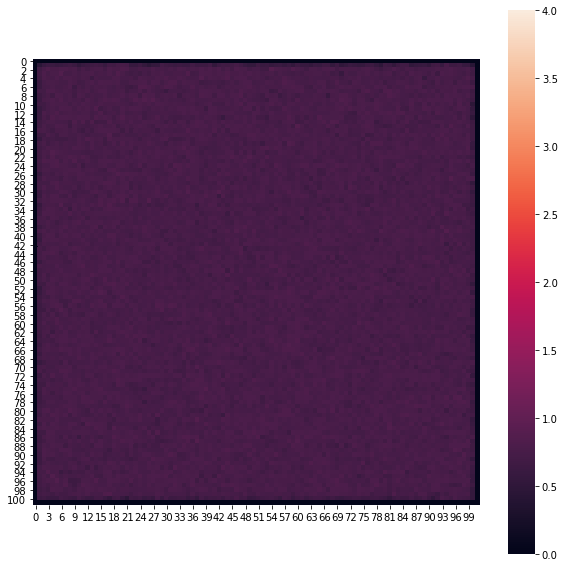

[13] loss: -1.988; Mean Information : 0.8111457228660583


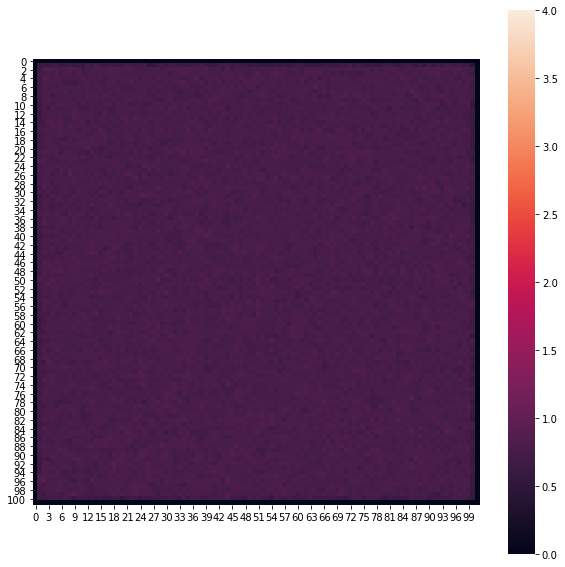

[14] loss: -1.989; Mean Information : 0.8217761516571045


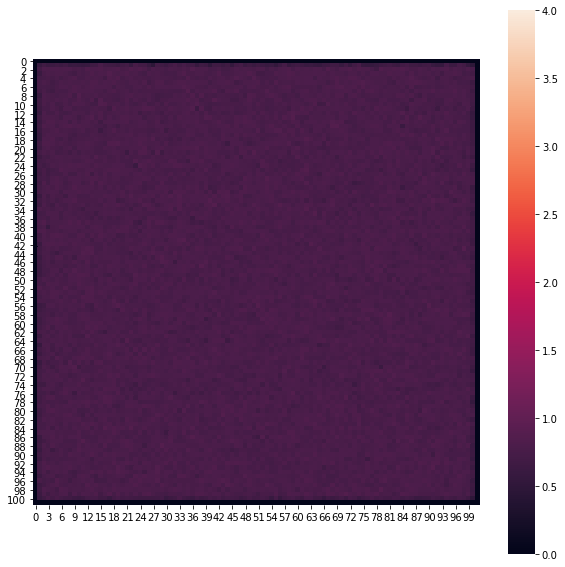

[15] loss: -1.990; Mean Information : 0.8331555724143982


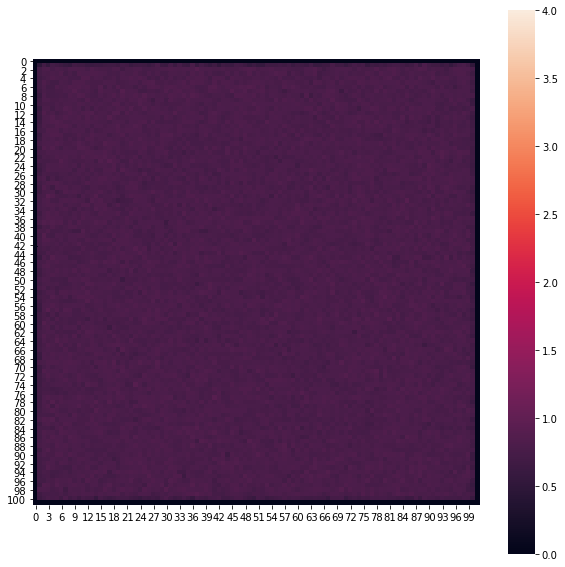

[16] loss: -1.991; Mean Information : 0.8401440978050232


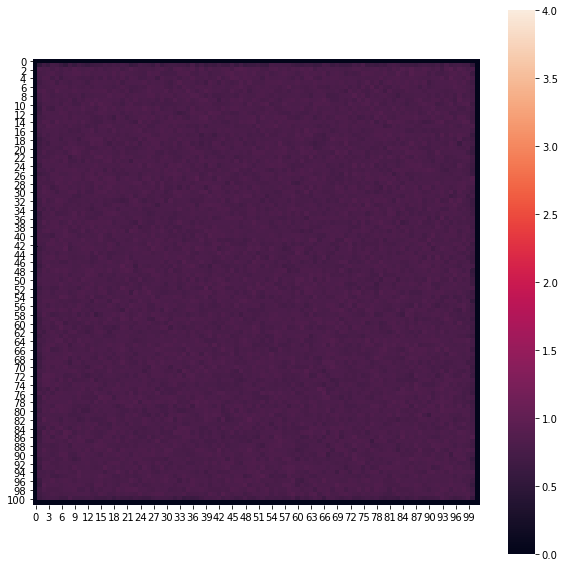

[17] loss: -1.992; Mean Information : 0.8465533256530762


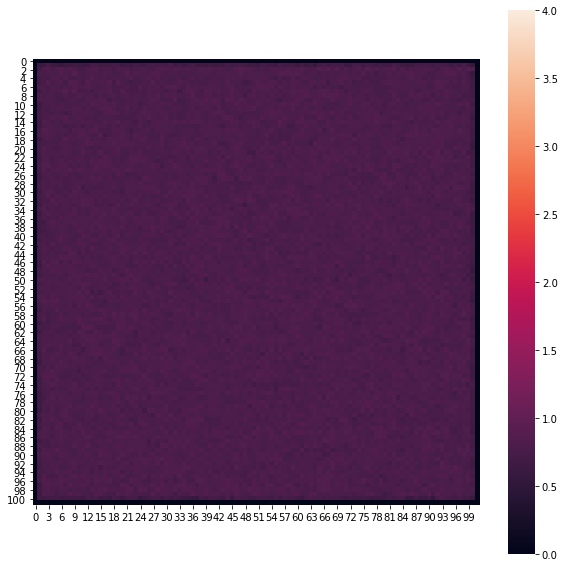

[18] loss: -1.993; Mean Information : 0.8543499112129211


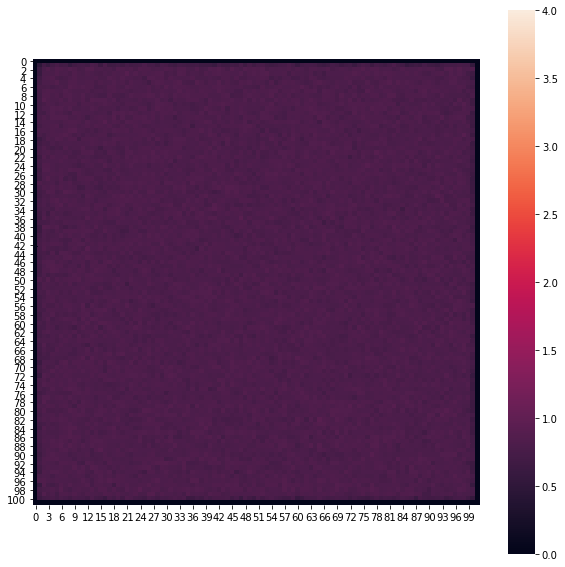

[19] loss: -1.993; Mean Information : 0.858845591545105


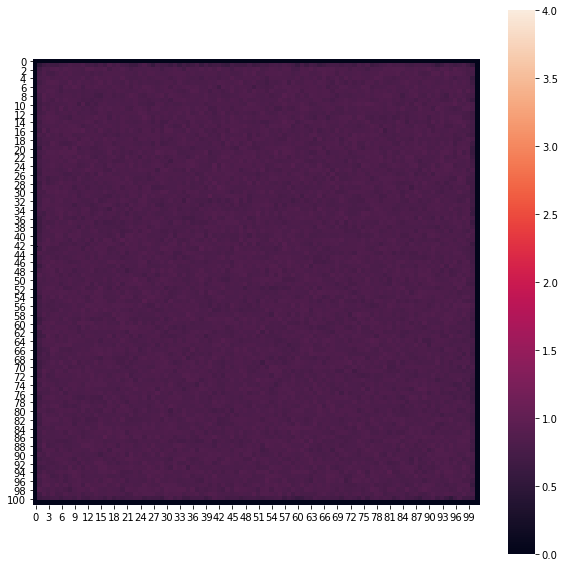

[20] loss: -1.994; Mean Information : 0.8652735948562622


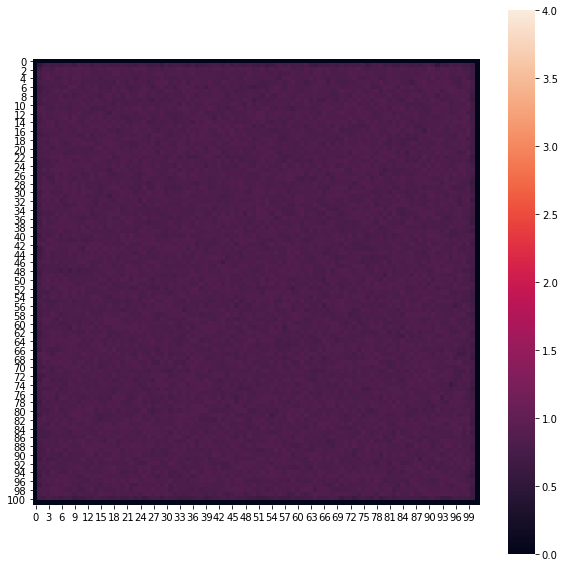

[21] loss: -1.994; Mean Information : 0.87220698595047


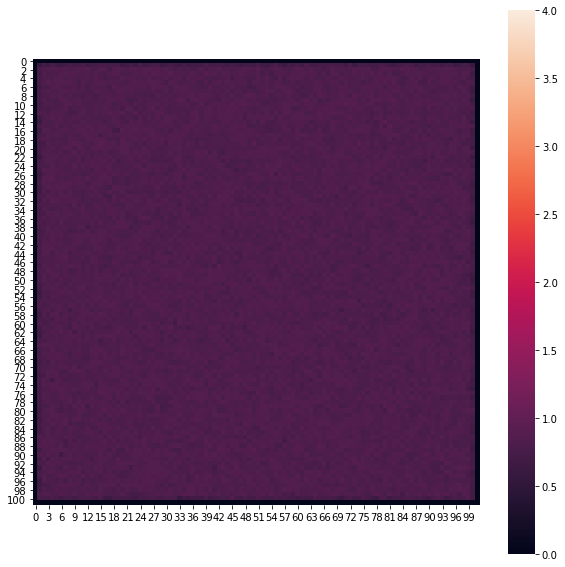

[22] loss: -1.995; Mean Information : 0.8780684471130371


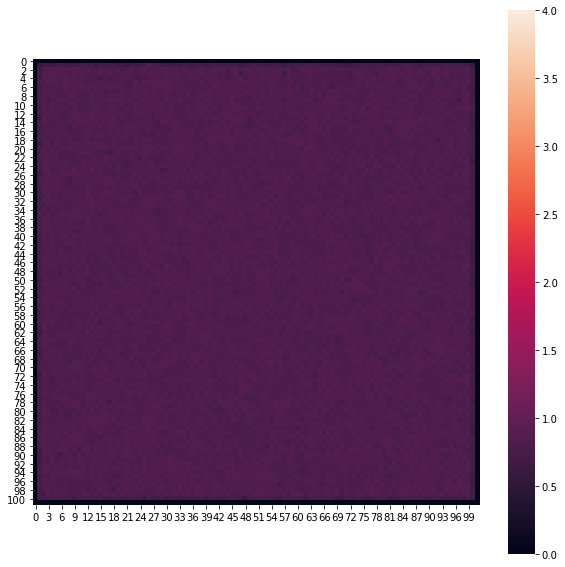

[23] loss: -1.995; Mean Information : 0.8787857294082642


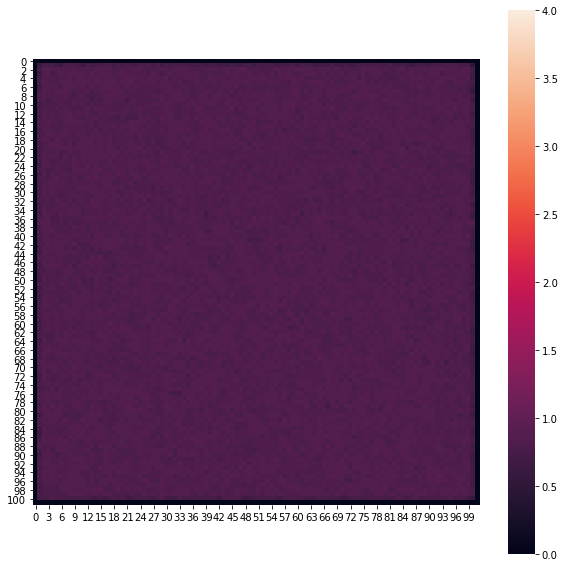

[24] loss: -1.995; Mean Information : 0.8859599232673645


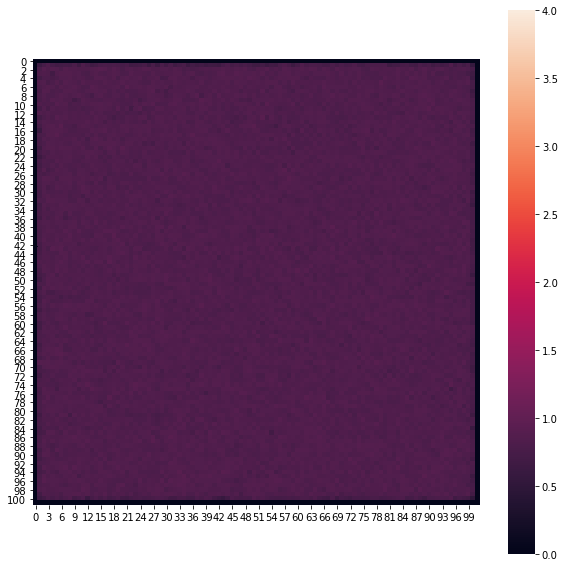

[25] loss: -1.995; Mean Information : 0.8876915574073792


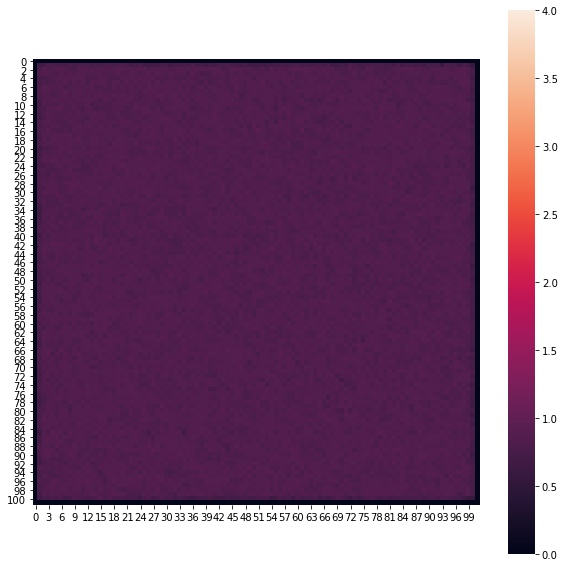

[26] loss: -1.996; Mean Information : 0.8904061913490295


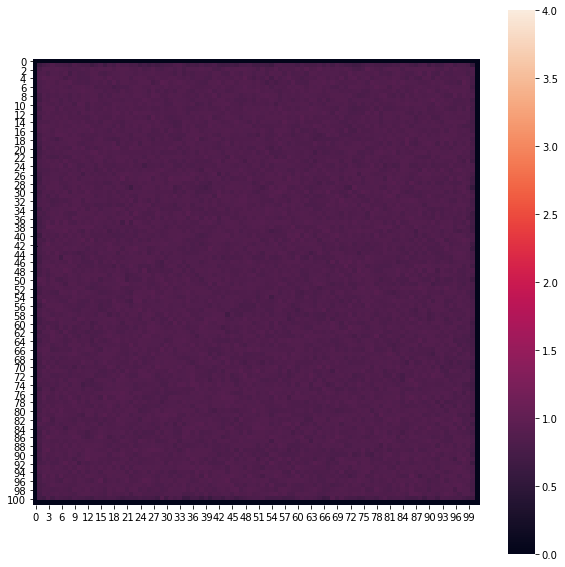

[27] loss: -1.996; Mean Information : 0.8970344066619873


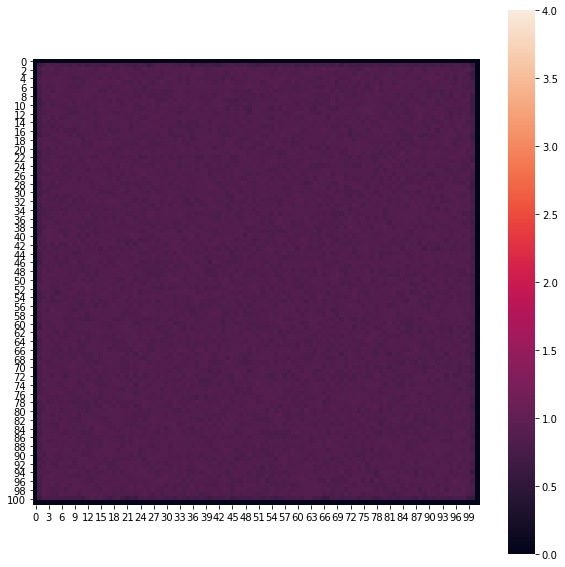

[28] loss: -1.996; Mean Information : 0.9021434187889099


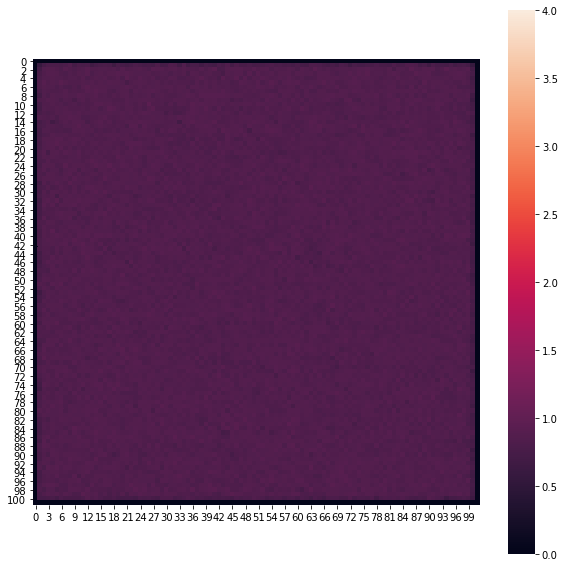

[29] loss: -1.996; Mean Information : 0.9059334993362427


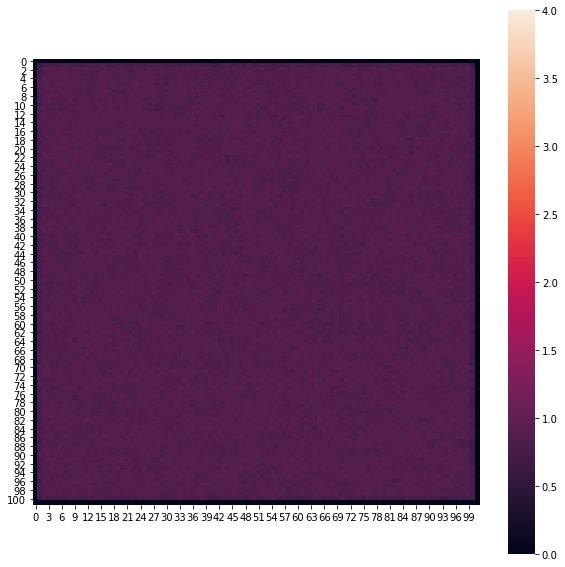

[30] loss: -1.996; Mean Information : 0.9076911211013794


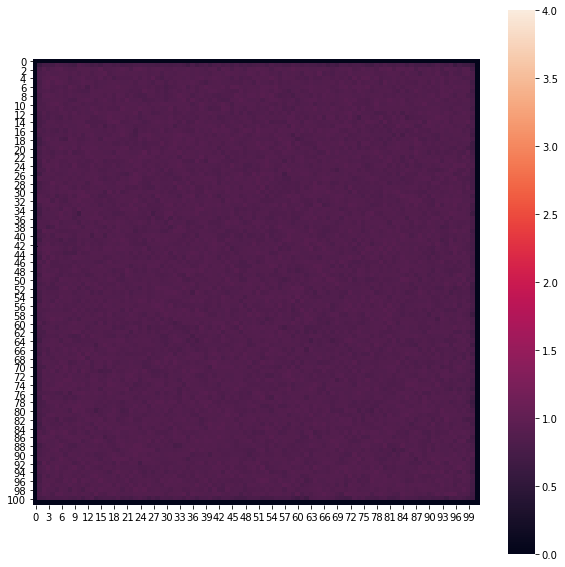

[31] loss: -1.997; Mean Information : 0.910492479801178


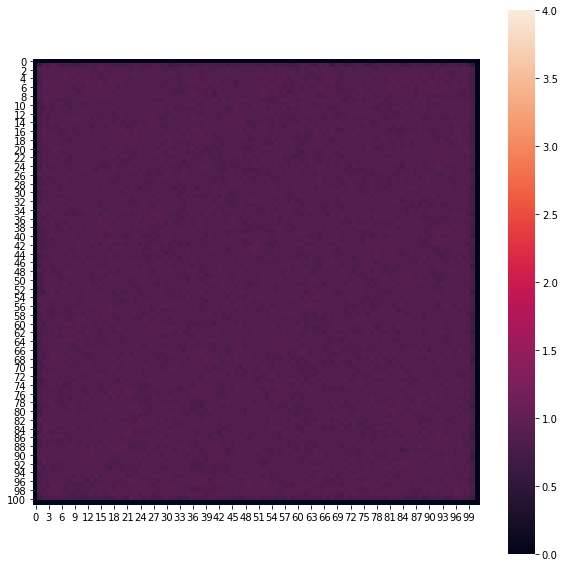

[32] loss: -1.997; Mean Information : 0.9152899384498596


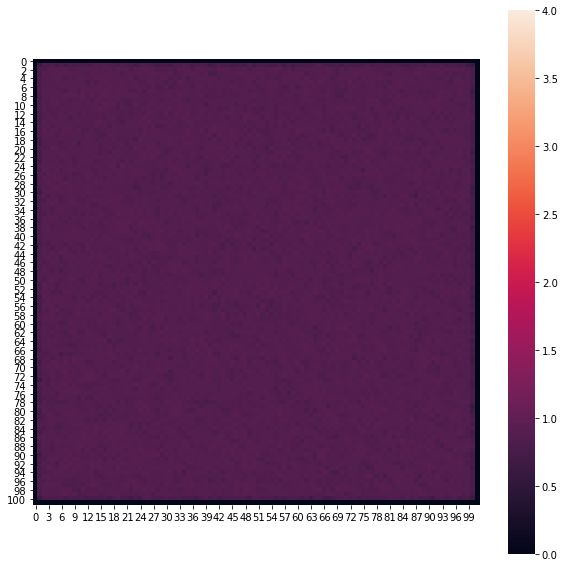

[33] loss: -1.997; Mean Information : 0.9175461530685425


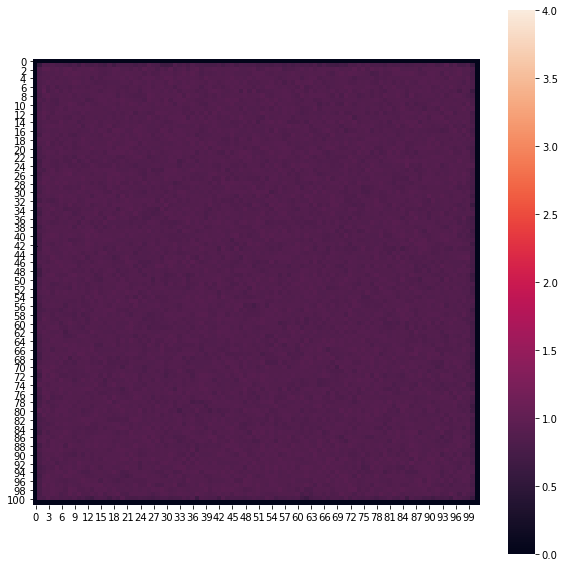

[34] loss: -1.997; Mean Information : 0.9227858781814575


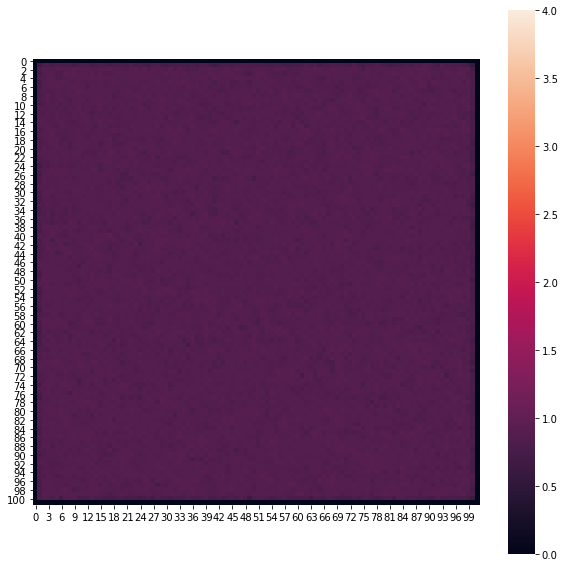

[35] loss: -1.997; Mean Information : 0.9252792596817017


In [ ]:
pump_energy = True
for e in range(epochs):
    new_field = torch.zeros(field_size, field_size, hidden_size)
    train_set = []
    for i in range(1, field_size - 1):
        for j in range(1, field_size - 1):
            tmp = []
            tmp.append(field[i, j].to(device))
            # верхние и боковые соседи
            tmp.append(torch.cat([field[i - 1, j], field[i + 1, j], field[i, j - 1], field[i, j + 1]]).to(device))
            # координаты поля
            tmp.append((i, j))
            train_set.append(tmp)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
    running_loss = 0.0
    for cells, neighbours, cords in train_loader:
        loc_y, loc_x = cords
        optimizer.zero_grad()
        reset, update, delta, state = net(cells, neighbours)
        loss = autism_loss(reset, update, delta, state)
        loss.backward()
        optimizer.step()
        for new_state, y, x in zip(state, loc_y, loc_x):
            new_field[y, x] = new_state
        # print statistics
        running_loss += loss.item()
    mean_information = torch.mean(field ** 2)
    with torch.no_grad():
        field = new_field.clone()
        fig, ax = plt.subplots(figsize=(10,10))   
        ax = sns.heatmap(torch.mean(field ** 2, axis = 2), ax=ax, square=True,  vmin = 0, vmax = 4)
        plt.show()
        if pump_energy:
            # эксмерементирую с константой, сколько нового рандома вносить
            field += torch.randn(field_size, field_size, hidden_size) * 0.3
    print(f'[{e + 1}] loss: {running_loss /  len(train_loader):.3f}; Mean Information : {torch.mean(field ** 2)}')

In [20]:
torch.save(net.state_dict(), 'models/first_model')